In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, classification_report,roc_auc_score,accuracy_score,recall_score,precision_score,f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Model Building

Since the outcome variable is categorical Logistic or Tree based models can be used for prediction.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [9]:
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

### 1. Logistic Regression

Model assumptions :

1. Outcome variable is categorical
2. Observations are independent of each other
3. No severe multicollinearity among X variables
4. No extreme outliers
5. Linear relationship between each X variable and the logit of the outcome variable
6. Sufficiently large sample size

In [10]:
# we have 2 object variables of which department is categorical and salary is categorical but ordinal

df_enc= df.copy()

df_enc['salary'] = df_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False



This code snippet is converting the salary column in the df_enc DataFrame from a string or object type into a numerical format by following these steps:

1. astype('category'): The salary column is first converted into a categorical data type. This tells pandas that the column should be treated as containing distinct categories (rather than raw text).
2. .cat.set_categories(['low', 'medium', 'high']): This specifies the explicit order of categories for the salary column. The categories are ordered as ['low', 'medium', 'high'], which is useful when you want to assign an ordinal relationship between the categories.
3. .cat.codes: After setting the categories, cat.codes converts the categorical values into their respective integer codes. In this case:
'low' is encoded as 0,
'medium' is encoded as 1,
'high' is encoded as 2

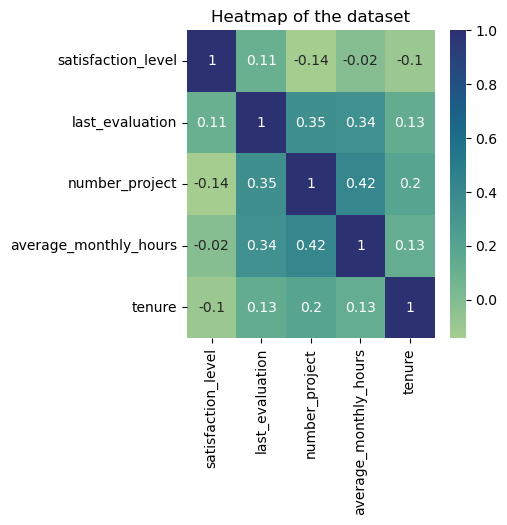

In [13]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(4, 4))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [15]:
## as we have observed outliers in tenure in EDA lets remove them as logistic regression is sensitve to outliers
# Define the upper limit and lower limit for non-outlier values in `tenure`
iqr = df_enc['tenure'].quantile(0.75) - df_enc['tenure'].quantile(0.25)
upper_limit = df_enc['tenure'].quantile(0.75) + 1.5 * iqr
lower_limit = df_enc['tenure'].quantile(0.25) - 1.5 * iqr

df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

In [28]:
df['left'].value_counts(normalize=True) # the data is not highly imbalanced

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

In [17]:
# Preparing data for modeling

y = df_logreg['left']
X = df_logreg.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

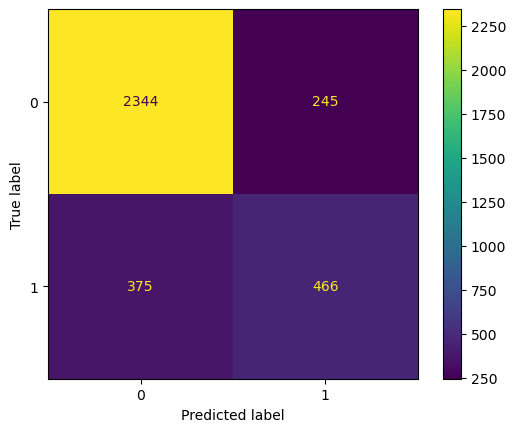

In [22]:
# Fitting the model

log_clf = LogisticRegression(random_state=42,max_iter=500).fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

log_cm = confusion_matrix(y_test,y_pred,labels=log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)
log_disp.plot(values_format='')

plt.show()

The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [32]:
targets =['predicted would not leave','predicted will leave'] # naming for better readability of report
print(classification_report(y_test,y_pred,target_names=targets))

                           precision    recall  f1-score   support

predicted would not leave       0.86      0.91      0.88      2589
     predicted will leave       0.66      0.55      0.60       841

                 accuracy                           0.82      3430
                macro avg       0.76      0.73      0.74      3430
             weighted avg       0.81      0.82      0.81      3430



The classification report above shows that the logistic regression model achieved a precision of 81%, recall of 82%, f1-score of 81% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

### Tree-based Model¶

#### Decision Tree

In [33]:
# as tree based models are not effected by outliers we dont need to remove the outliers in tenure use df_enc
y = df_enc['left']
X = df_enc.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [40]:
tree = DecisionTreeClassifier(random_state=0)
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [41]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 2.14 s, sys: 53.8 ms, total: 2.2 s
Wall time: 2.23 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [42]:
# optimal values for the decision tree parameters.
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [43]:
tree1.best_score_

0.9814534932565159

This is a strong AUC score, which shows that this model can predict employees who will leave very well.
Next, you can write a function that will help you extract all the scores from the grid search.

In [44]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [53]:
tree_cv_results = make_results('decision tree cv', tree1, 'auc')
tree_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.962687,0.930913,0.946462,0.974931,0.981453


All of these scores from the decision tree model are strong indicators of good model performance.
Recall that decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. You could construct a random forest model next.

#### Random Forest

In [51]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [52]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 16min 28s, sys: 13.3 s, total: 16min 41s
Wall time: 16min 50s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [128]:
import os
import pickle
def write_pickle(path, model_object, save_as: str):
    '''
    In: 
        path:         path of the folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)

    # Save the model as a pickle file
    with open(os.path.join(path, save_as + '.pickle'), 'wb') as to_write:
        pickle.dump(model_object, to_write)
    
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path+'/' + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [125]:
path = os.getcwd()

In [126]:
write_pickle(path, rf1, 'hr_rf1')

In [108]:
rf1 = read_pickle(path, 'hr_rf1')

In [109]:
rf1.best_score_

0.9907974638454224

In [110]:
# optimal values for the parameters of the random forest model.
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [56]:
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
tree_cv_results = pd.concat([tree_cv_results,rf1_cv_results])
tree_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.962687,0.930913,0.946462,0.974931,0.981453
0,random forest cv,0.990386,0.920834,0.954322,0.979020,0.990797


In [61]:
# Evaluating the champion model random_forest on test data
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [70]:
y_pred = rf1.predict(X_test)
targets =['predicted would not leave','predicted will leave'] # naming for better readability of report
print(classification_report(y_test,y_pred,target_names=targets))


                           precision    recall  f1-score   support

predicted would not leave       0.98      1.00      0.99      2857
     predicted will leave       1.00      0.93      0.96       893

                 accuracy                           0.98      3750
                macro avg       0.99      0.96      0.97      3750
             weighted avg       0.98      0.98      0.98      3750



In [69]:
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.995204,0.929451,0.961204,0.982133,0.964026


The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, you can be more confident that your model's performance on this data is representative of how it will perform on new, unseeen data.

### Some other points to be considered

The evaluation scores of the rf1 model is pretty high which may lead us to check if there is any data leakage. Data leakage is when you use data to train your model that should not be used during training, either because it appears in the test data or because it's not data that you'd expect to have when the model is actually deployed. Training a model with leaked data can give an unrealistic score that is not replicated in production. There are issues with satisfaction_level, average_monthly_hours.

1.  The key issue with satisfaction_level is that it could be influenced by decisions the employee has already made, such as deciding to quit. If an employee has already decided to leave, their reported satisfaction level might drop significantly, reflecting their decision rather than their general state over time.  In a real-world scenario, when you're trying to predict if an employee will quit, you wouldn’t have access to their future satisfaction levels (e.g., satisfaction right before they quit). If this feature reflects an employee's satisfaction after they’ve already mentally checked out, it’s leaking information about the outcome (quitting) back into the training process. This creates an unrealistically strong predictor, leading to overfitting.

2.  Similar to satisfaction, average_monthly_hours might not be purely predictive of quitting. For instance, if an employee is planning to quit or has been flagged for potential termination, they might start working fewer hours. This means that a drop in hours could be a result of the impending decision to quit, not a cause. At the time of predicting whether an employee will quit, you wouldn’t typically know if they’re going to reduce their hours in the future. If the training data includes cases where hours have already dropped because the employee is close to quitting, the model could mistakenly learn to associate lower hours with quitting, even though that drop in hours is actually a consequence of their decision rather than an independent predictor.

If the features are influenced by the outcome you’re trying to predict (e.g., quitting), they can make the model appear more predictive than it really is in practice.

The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models.

You could proceed by dropping satisfaction_level and creating a new feature that roughly captures whether an employee is overworked. You could call this new feature overworked. It will be a binary variable.

In [74]:
df2 = df_enc.drop('satisfaction_level', axis=1)
# Create `overworked` column. For now, it's identical to average monthly hours.
df2['overworked'] = df2['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df2['overworked'].max())
print('Min hours:', df2['overworked'].min())

# Define `overworked` as working > 175 hrs/week
df2['overworked'] = (df2['overworked'] > 175).astype(int)
# Drop the `average_monthly_hours` column
df2 = df2.drop('average_monthly_hours', axis=1)
df2.head()

Max hours: 310
Min hours: 96


,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day.

You could define being overworked as working more than 175 hours per month on average.

To make the overworked column binary, you could reassign the column using a boolean mask.

    1. df3['overworked'] > 175 creates a series of booleans, consisting of True for every value > 175 and False for every values ≤ 175
    2. .astype(int) converts all True to 1 and all False to 0

In [75]:
# Isolate the outcome variable
y = df2['left']

# Select the features
X = df2.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

#### Decision Tree 2

In [83]:
tree = DecisionTreeClassifier(random_state = 0)
# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [84]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 1.7 s, sys: 75.6 ms, total: 1.77 s
Wall time: 1.79 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [86]:
tree2.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [87]:
tree2.best_score_

0.9705030355050686

In [88]:
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
tree_cv_results = pd.concat([tree_cv_results,tree2_cv_results])
tree_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.962687,0.930913,0.946462,0.974931,0.981453
0,random forest cv,0.990386,0.920834,0.954322,0.979020,0.990797
0,decision tree2 cv,0.916591,0.891332,0.903665,0.954752,0.970503


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

#### Random Forest 2

In [91]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [115]:
%%time
rf2.fit(X_train, y_train) 

CPU times: user 11min 11s, sys: 18.3 s, total: 11min 30s
Wall time: 11min 36s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [123]:
path=os.getcwd()

'/Users/amruthakaruturi/Desktop/ml/HRProject'

In [124]:
write_pickle(path, rf2, 'hr_rf2')

In [129]:
rf2 = read_pickle(path, 'hr_rf2')

In [130]:
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [131]:
rf2.best_score_

0.9800231293705679

In [132]:
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
tree_cv_results = pd.concat([tree_cv_results,rf2_cv_results])
tree_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.962687,0.930913,0.946462,0.974931,0.981453
0,random forest cv,0.990386,0.920834,0.954322,0.979020,0.990797
0,decision tree2 cv,0.916591,0.891332,0.903665,0.954752,0.970503
0,random forest2 cv,0.933895,0.907015,0.920104,0.962486,0.980023


Again, the scores dropped slightly, but the random forest performs better than the decision tree if using AUC as the deciding metric.
Score the champion model on the test set now.

In [133]:
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest2 test,0.933258,0.923852,0.928531,0.966133,0.951601


In [134]:
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.995204,0.929451,0.961204,0.982133,0.964026


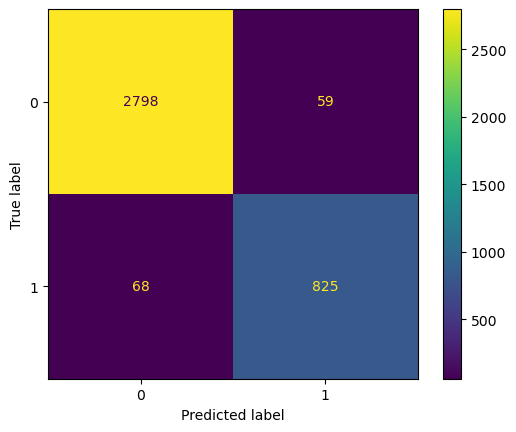

In [135]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.

#### Feature Importance

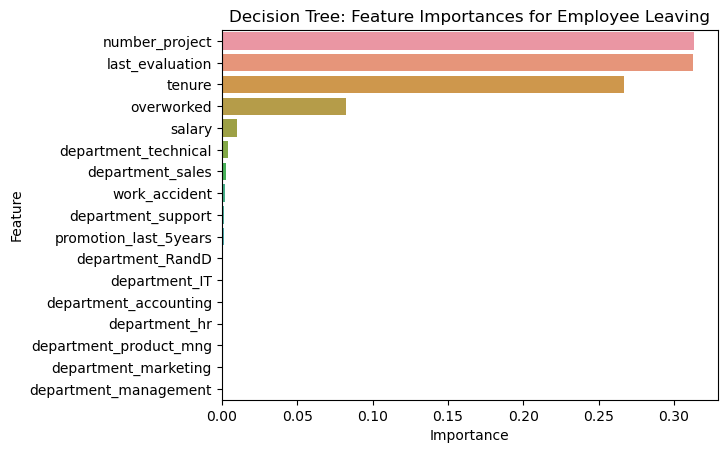

In [136]:
### Decision Tree
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

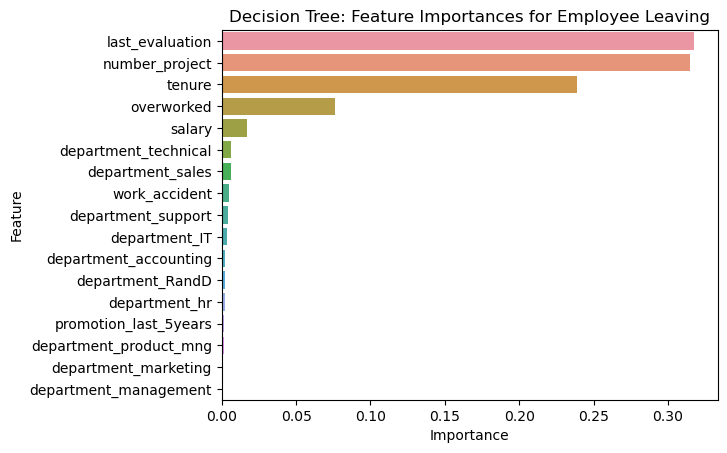

In [145]:
# Random Forest
rf2_importances = pd.DataFrame(rf2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
rf2_importances = rf2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
rf2_importances = rf2_importances[rf2_importances['gini_importance'] != 0]
rf2_importances

sns.barplot(data=rf2_importances, x="gini_importance", y=rf2_importances.index, orient='h')
plt.title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The plot above shows that in this random forest model, **last_evaluation, number_project, tenure** , and **overworked** have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left, and they are the same as the ones used by the decision tree model.

### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 81%, recall of 82%, f1-score of 81% (all weighted averages), and accuracy of 82%, on the test set.However, if it's most important to predict employees who leave, then the scores are significantly lower.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 97.05%, precision of 91.65%, recall of 89.13%, f1-score of 90.36%, and accuracy of 95.47%, on the test set. The random forest modestly outperformed the decision tree model. 

### Recommendations 

The models and the feature importances extracted from the models confirm that employees at the company are overworked.
To retain employees, the following recommendations could be presented to the stakeholders:
1. Cap the number of projects that employees can work on.
2. Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
3. Either reward employees for working longer hours, or don't require them to do so.
4. If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.
5. Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
6. High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.